# A notebook to tine multi-label classification in keras tensorflow

https://www.analyticsvidhya.com/blog/2017/08/introduction-to-multi-label-classification




In [1]:
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.ticker import MaxNLocator
import numpy as np
from numpy import asarray
import pandas as pd
import math
import seaborn as sns  #heat map
import glob # batch processing of images


import matplotlib.font_manager as fm
import random
import sys
import os

from sklearn.datasets import make_regression
import tensorflow as tf
from sklearn.metrics import confusion_matrix    #confusion matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Collect all the font names available to matplotlib
font_names = [f.name for f in fm.fontManager.ttflist]
# print(font_names)

from scipy import signal
from scipy import interpolate

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve 
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score


from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.gaussian_process.kernels import RBF

#Sklearn model saving and loading
from joblib import dump, load

if '../../' not in sys.path:
    sys.path.append('../../')

from aimos.spectral_datasets.THz_datasets import THz_data

from aimos.misc.utils import simple_plotter


#Set random seed
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
tf.random.set_seed(42)  
tf.random.get_global_generator().reset_from_seed(42)
np.random.seed(42)
random.seed(42)
import pydot
import graphviz


2022-08-04 19:45:22.088445: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-08-04 19:45:29.255644: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-08-04 19:45:29.345576: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: Quadro RTX 4000 computeCapability: 7.5
coreClock: 1.545GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 387.49GiB/s
2022-08-04 19:45:29.345661: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-08-04 19:45:29.582796: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-08-04 19:45:29.583009: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so

In [2]:
from oneida import THz_mixture_data

In [3]:
def concentrations_to_one_hot_encode(y):
    '''
    args:
    y, a vector containing the concentration values for each component.
    
    return vector containing binary one hot encoding
    '''
    
    
    y_ohe = y
    for i in range(y.shape[0]):

        for j in range(y.shape[1]):
            if y[i][j] > 0:
                y_ohe[i][j]=1    
                
    return y_ohe

In [4]:
def create_mixture_names(ohe_label,n_mixture_component_max,reduced_labels):
    
    '''
    args:
    ohe_label: a one-hot encoded label corresponding to a mixture with components in it contain.
    n_mixture_component_max: maximum number of pure components in the mixture.
    reduced_labels: label list containing the names of only the pure mixtures.
    
    
    '''
    
    
    capture_labels=[]
    for _ in range(n_mixture_component_max):
        if ohe_label[_]==1:
            capture_labels.append(reduced_labels[_])
        
        
    mixture_name_label=""
    for i in capture_labels:
        mixture_name_label+= i +"+"

    
    
    
    return mixture_name_label.strip(mixture_name_label[-1])

In [5]:
import operator as op
from functools import reduce

def ncr(n, r):
    r = min(r, n-r)
    numer = reduce(op.mul, range(n, n-r, -1), 1)
    denom = reduce(op.mul, range(1, r+1), 1)
    return numer // denom  # or / in Python 2

In [6]:
def grad_cam(layer_name, data, model):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )
    last_conv_layer_output, preds = grad_model(data)

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(data)
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0))

    last_conv_layer_output = last_conv_layer_output[0]

    heatmap = last_conv_layer_output * pooled_grads
    heatmap = tf.reduce_mean(heatmap, axis=(1))
    heatmap = np.expand_dims(heatmap,0)
    return heatmap

# layer_name = "C3"

# font = {'family': 'serif',
#         'color':  'black',
#         'weight': 'bold',
#         'size': 16,
#         }


# count = 0
# for i,j in zip(Xexp,yexp):
    
#     data = np.expand_dims(i,0)
#     heatmap = grad_cam(layer_name,data)

#     fig = plt.figure(figsize=(30,4),dpi=300)
#     plt.imshow(np.expand_dims(heatmap,axis=2),cmap='YlGnBu', aspect="auto", interpolation='nearest',extent=[0,229,i.min(),i.max()], alpha=0.8)
    
#     ticklist = range(0,229)
#     plt.xticks(ticklist[::30], np.round(s.frequencies.tolist()[::30], decimals=1) ) # tick every 40th frequency
#     plt.plot(i,'k')
#     plt.title(f'{s.labels[j]}', fontdict=font)
#     plt.colorbar()
#     plt.clim(np.min(heatmap),np.max(heatmap))
    
#     plt.show()
    
#     fig.savefig(r'RESULTS/class_activation_maps/CAM_exp' + str(count) + '.png', bbox_inches='tight')
#     count = count + 1

# Create controlled test mixtures

In [7]:
m = THz_mixture_data(resolution=0.001, pressure='1 Torr', verbosity=False)
m.initiate_THz_mixture_data()

Components :  [[0 1 2 3 4 5]]
Components shape :  (1, 6)


In [8]:
reduced_labels = m.labels
reduced_labels.remove('')
reduced_labels.remove(' ')
reduced_labels.remove('Diluent')
print(reduced_labels)


['$CH_3CHO$', '$CH_3Cl$', '$CH_3CN$', '$CH_3OH$', '$HNO_3$']


In [9]:
# m.make_controlled_test_mixtures(equal_amount = 10000, tweleve_component_amount=10000,
#                                 abs_threshold=0.001, test_Species_Abs_Threshold=0.0001,
#                                 save_to_file = False)


#TO-do fix error when there is no indices to remove
# 200000
m.make_controlled_test_mixtures(equal_amount = 5000,
                                abs_threshold=0.001, test_Species_Abs_Threshold=0.0001,
                                save_to_file = False)


 ...generating 1-component mixtures data...


 ...generating 2-component mixtures data...


 ...generating 3-component mixtures data...


 ...generating 4-component mixtures data...


 ...generating 5-component mixtures data...

Time elasped: 669.0930000000001
Total number of test mixtures :  25000

Combined test simulated mixtures

No. of test mixtures:  25000
test_targets data type:  object
test_targets data shape:  (25000, 5)
Time elaspsed:  20478.662
numpy random state:  804035397
test_mixtures data type:  object
test_mixtures shape:  (24977, 1, 3670)
test_targets data type:  object
test_targets shape:  (24977, 5)
Adjusted n_test_mixtures:  24977
Total spectra with weak components in testing dataset: (77,)
test_mixtures data type:  object
test_mixtures shape:  (24900, 5)
test_targets data type:  object
test_targets shape:  (24900, 5)
Adjusted n_test_mixtures after removing spectra with weak components:  24900


In [10]:
n_compounds = m.n_compounds
unique_mixture_numbers = ncr(n_compounds,1) + ncr(n_compounds,2) + ncr(n_compounds,3) + ncr(n_compounds,4) + ncr(n_compounds,5) 
# unique_mixture_numbers = ncr(n_compounds,1) + ncr(n_compounds,2) + ncr(n_compounds,3) + ncr(n_compounds,4) + ncr(n_compounds,5) + ncr(n_compounds,6) + ncr(n_compounds,7) +ncr(n_compounds,8) + ncr(n_compounds,9) + ncr(n_compounds,10) + ncr(n_compounds,11) + ncr(n_compounds,12)
print(unique_mixture_numbers)

31


# view attributes of the controlled test mixtures data

In [11]:
print('number of test mixtures: ',m.n_test_mixtures)
print('test mixtures shape: ',m.test_mixtures.shape)
print('test targets shape: ',m.test_targets.shape)
print('test dilutions shape: ',m.test_dilution.shape)

print('resolution: ',m.resolution)
print('frequencies in the data', m.frequencies)

print('pressure: ',m.pressure) 
print('labels: ',m.labels) 
print('label_id: ',m.label_id) 

print('number of features: ',m.n_features) 
print('no. of compounds: ',m.n_compounds)
print('no. of spectrum per compound in pure THz data: ' ,m.n_spectrum)
print('no. of spectra in pure THz data: ',m.n_spectra) 

print('number ot maximum mixture components: ',m.n_mixture_component_max)
print('integer indices for each of the mixture components',m.components)


number of test mixtures:  24900
test mixtures shape:  (24900, 3670)
test targets shape:  (24900, 5)
test dilutions shape:  (25000,)
resolution:  0.001
frequencies in the data [ 7.331  7.332  7.333 ... 10.998 10.999 11.   ]
pressure:  1 Torr
labels:  ['$CH_3CHO$', '$CH_3Cl$', '$CH_3CN$', '$CH_3OH$', '$HNO_3$']
label_id:  [ 0  1  2  3  4  5  6  7  8  9 10 11]
number of features:  3670
no. of compounds:  5
no. of spectrum per compound in pure THz data:  164
no. of spectra in pure THz data:  1968
number ot maximum mixture components:  5
integer indices for each of the mixture components [[0 1 2 3 4 5]]


# assign controlled test mixtures data

In [12]:
X=m.test_mixtures

y_concentrations=m.test_targets

print('X shape:', X.shape)
print('y_concentrations shape:', y_concentrations.shape)

print('X dtype:', X.dtype)
print('y_concentrations dtype:', y_concentrations.dtype)

X=X.astype(np.float)
y_concentrations=y_concentrations.astype(np.float)

print('After data type conversion')
print('X dtype:', X.dtype)
print('y_concentrations dtype:', y_concentrations.dtype)

X shape: (24900, 3670)
y_concentrations shape: (24900, 5)
X dtype: object
y_concentrations dtype: object
After data type conversion
X dtype: float64
y_concentrations dtype: float64


/tmp/ipykernel_5427/1008626817.py:11: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X=X.astype(np.float)
/tmp/ipykernel_5427/1008626817.py:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_concentrations=y_concentrations.astype(np.float)


In [13]:
y_ohe = concentrations_to_one_hot_encode(y_concentrations)

In [14]:
# create_mixture_names(y_ohe[200],m.n_mixture_component_max,reduced_labels)

mixture_names= []
for _ in range(y_ohe.shape[0]):
    mixture_names.append(create_mixture_names(y_ohe[_],m.n_mixture_component_max,reduced_labels))

    
# for _ in range(y_ohe.shape[0]):
#     print(mixture_names[_])

In [15]:
# mixture_names

In [16]:
#encode mixture names as integer index

from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(mixture_names)
y = le.transform(mixture_names)

# le.inverse_transform(y)
mixture_types=le.classes_
print(mixture_types)

['$CH_3CHO$' '$CH_3CHO$+$CH_3CN$' '$CH_3CHO$+$CH_3CN$+$CH_3OH$'
 '$CH_3CHO$+$CH_3CN$+$CH_3OH$+$HNO_3$' '$CH_3CHO$+$CH_3CN$+$HNO_3$'
 '$CH_3CHO$+$CH_3Cl$' '$CH_3CHO$+$CH_3Cl$+$CH_3CN$'
 '$CH_3CHO$+$CH_3Cl$+$CH_3CN$+$CH_3OH$'
 '$CH_3CHO$+$CH_3Cl$+$CH_3CN$+$CH_3OH$+$HNO_3$'
 '$CH_3CHO$+$CH_3Cl$+$CH_3CN$+$HNO_3$' '$CH_3CHO$+$CH_3Cl$+$CH_3OH$'
 '$CH_3CHO$+$CH_3Cl$+$CH_3OH$+$HNO_3$' '$CH_3CHO$+$CH_3Cl$+$HNO_3$'
 '$CH_3CHO$+$CH_3OH$' '$CH_3CHO$+$CH_3OH$+$HNO_3$' '$CH_3CHO$+$HNO_3$'
 '$CH_3CN$' '$CH_3CN$+$CH_3OH$' '$CH_3CN$+$CH_3OH$+$HNO_3$'
 '$CH_3CN$+$HNO_3$' '$CH_3Cl$' '$CH_3Cl$+$CH_3CN$'
 '$CH_3Cl$+$CH_3CN$+$CH_3OH$' '$CH_3Cl$+$CH_3CN$+$CH_3OH$+$HNO_3$'
 '$CH_3Cl$+$CH_3CN$+$HNO_3$' '$CH_3Cl$+$CH_3OH$'
 '$CH_3Cl$+$CH_3OH$+$HNO_3$' '$CH_3Cl$+$HNO_3$' '$CH_3OH$'
 '$CH_3OH$+$HNO_3$' '$HNO_3$']


In [17]:
# for _ in range(y_ohe.shape[0]):
#     print(mixture_names[_],integers[_])

In [18]:
y.shape

(24900,)

In [19]:
final_neuron_number = np.unique(y, axis=0).shape[0]
print(final_neuron_number)

31


# preview one test mixture spectra using simple plotter

In [20]:
# simple_plotter(m.frequencies,m.test_mixtures[0],linewidth=0.5,color='black',label='$test-mixture$', 
#                    majorsize=6,minorsize=2,width=1, labelsize=8,legendsize=3, legendloc=2,  
#                    labelpad=4,fontsize='medium',fontweight='bold',
#                   xmajormplloc=0.5,xminormplloc=0.2, tickdirection='out')

In [21]:
X.shape

(24900, 3670)

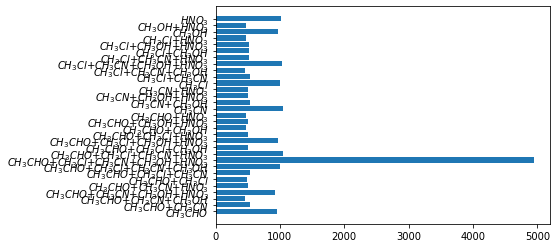

In [22]:
#see distribution of counts of different types of mixtures.
plt.barh(mixture_types,np.bincount(y))
plt.xticks(rotation=90);
plt.xticks(rotation=0);

In [23]:
spectra_df = pd.DataFrame(X)
spectra_df['y'] = y
spectra_df['mixture_names'] = mixture_names

In [24]:
mixtures_df_list = []
for label in mixture_types:
    mixtures_df_list.append(spectra_df[spectra_df['mixture_names'] ==label] )

In [25]:
# 2000
filtered_mixtures_df_list = []
for df in mixtures_df_list:
    filtered_mixtures_df_list.append(df.sample(n=300))

filtered_spectra_df = pd.concat(filtered_mixtures_df_list)    

In [26]:
filtered_spectra_df.head()

,0,1,2,3,4,5,6,7,8,9,...,3662,3663,3664,3665,3666,3667,3668,3669,y,mixture_names
221,0.006019,0.005470,0.004342,0.003278,0.002501,0.001985,0.001658,0.001474,0.001400,0.001428,...,0.040994,0.035504,0.029645,0.025014,0.021801,0.019685,0.018030,0.016170,0,$CH_3CHO$
2635,0.009416,0.008558,0.006792,0.005128,0.003912,0.003105,0.002594,0.002305,0.002190,0.002234,...,0.064128,0.055540,0.046374,0.039130,0.034104,0.030793,0.028205,0.025295,0,$CH_3CHO$
3294,0.019887,0.018074,0.014345,0.010831,0.008263,0.006557,0.005478,0.004868,0.004625,0.004719,...,0.135439,0.117300,0.097943,0.082643,0.072028,0.065035,0.059569,0.053423,0,$CH_3CHO$
4993,0.018793,0.017080,0.013556,0.010235,0.007808,0.006197,0.005177,0.004601,0.004371,0.004459,...,0.127991,0.110850,0.092557,0.078098,0.068067,0.061458,0.056293,0.050485,0,$CH_3CHO$
4144,0.020698,0.018811,0.014930,0.011273,0.008600,0.006825,0.005701,0.005067,0.004814,0.004911,...,0.140965,0.122086,0.101939,0.086015,0.074967,0.067688,0.061999,0.055603,0,$CH_3CHO$


In [27]:
# filtered_spectra_df[filtered_spectra_df['y']==0]

In [28]:
y_filtered = filtered_spectra_df['y'].to_numpy()
mixture_names_filtered = filtered_spectra_df['mixture_names'].to_numpy()
X_filtered = filtered_spectra_df.drop(['y', 'mixture_names'],axis=1).to_numpy()

In [29]:
y = y_filtered
X= X_filtered
mixture_names =  mixture_names_filtered

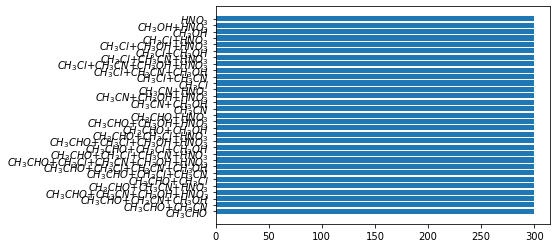

In [30]:
#see distribution of counts of different types of mixtures.
plt.barh(mixture_types,np.bincount(y))
plt.xticks(rotation=90);
plt.xticks(rotation=0);

In [31]:
#split intro train and test set

#seeds used 123,237, 786
from sklearn.model_selection import train_test_split

global_indices=range(0, X.shape[0])
print(global_indices)

# (np.expand_dims(X,-1)
TRAIN_SIZE=0.30
TEST_SIZE=1-TRAIN_SIZE

x_train, x_test, y_train, y_test, train_indices, test_indices = train_test_split(np.expand_dims(X, axis=-1), y, global_indices, train_size=TRAIN_SIZE,
                                                   test_size=TEST_SIZE,
                                                   random_state=786,
                                                    stratify=y

                                                   )

print('X_train shape:', x_train.shape)
print('y_ohe_train shape:', y_train.shape)

print('X_test shape:', x_test.shape)
print('y_ohe_test shape:', y_test.shape)


print("All:", np.bincount(y) / float(len(y))*100  )
print("Training:", np.bincount(y_train) / float(len(y_train))*100  )
print("Testing:", np.bincount(y_test) / float(len(y_test))*100  )


range(0, 9300)
X_train shape: (2790, 3670, 1)
y_ohe_train shape: (2790,)
X_test shape: (6510, 3670, 1)
y_ohe_test shape: (6510,)
All: [3.22580645 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645
 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645
 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645
 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645
 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645
 3.22580645]
Training: [3.22580645 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645
 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645
 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645
 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645
 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645
 3.22580645]
Testing: [3.22580645 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645
 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645
 3.22580645 3.225

In [54]:
def mixture_model(hp):

    model = models.Sequential()
    
#     hp_filters= hp.Int('filters', min_value=2, max_value=4, step=1)
#     hp_kernel_size= hp.Int('kernel_size', min_value=10, max_value=60, step=20)
#     hp_pool_size=hp.Int('pool_size', min_value=20, max_value=60, step=20)
#     hp_stride_size=hp.Int('stride_size', min_value=2, max_value=3, step=1)
#     hp_units= hp.Int('units', min_value=24, max_value=48, step=6)
    
    hp_filters= 3
    hp_kernel_size= hp.Int('kernel_size', min_value=10, max_value=60, step=20)
    hp_pool_size=hp.Int('pool_size', min_value=20, max_value=60, step=20)
    hp_stride_size=hp.Int('stride_size', min_value=2, max_value=3, step=1)
    hp_units= hp.Int('units', min_value=24, max_value=48, step=6)
#     hp_dropout = hp.Choice('dropout', values=[0.3, 0.5, 0.7])
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model = models.Sequential()

    # C1 Convolutional Layer
    model.add(layers.Conv1D(filters = hp_filters , kernel_size=hp_kernel_size, activation='relu', input_shape=(3670, 1), name = 'C1') )

    # S2 Subsampling Layer
    model.add(layers.AveragePooling1D(pool_size = hp_pool_size, strides = hp_stride_size, padding = 'valid', name = 'S2'))
    
    # C3 Convolutional Layer
    model.add(layers.Conv1D(filters = hp_filters , kernel_size=hp_kernel_size, activation='relu', name = 'C3') )
    
    # S4 Subsampling Layer
    model.add(layers.AveragePooling1D(pool_size = hp_pool_size, strides = hp_stride_size, padding = 'valid', name = 'S4'))
    
    # C5 Convolutional Layer
    model.add(layers.Conv1D(filters = hp_filters , kernel_size=hp_kernel_size, activation='relu', name = 'C5') )
    
    # S6 Subsampling Layer
    model.add(layers.AveragePooling1D(pool_size = hp_pool_size, strides = hp_stride_size, padding = 'valid', name = 'S6'))
    
    # C7 Convolutional Layer
    model.add(layers.Conv1D(filters = hp_filters , kernel_size=hp_kernel_size, activation='relu', name = 'C7') )
    
#

    # Flatten the CNN output to feed it with fully connected layers
    model.add(layers.Flatten())
    
    model.add(layers.Dense(hp_units, activation='relu')) 
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(31))  # number of dense layer would be equal to number of classess
    

    

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 metrics=[
              tf.keras.losses.SparseCategoricalCrossentropy(
                  from_logits=True, name='SparseCatCrossentropy'),
              'accuracy'])
    
    model.summary()
    
    return model

In [55]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import regularizers

import tensorflow_docs.plots
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling



import pathlib
import shutil
import tempfile
from tensorflow import keras
import keras_tuner as kt
tuner = kt.Hyperband(mixture_model,
                     objective='accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='keras_hp_tuner',
                     project_name='mixture_model')

INFO:tensorflow:Reloading Oracle from existing project keras_hp_tuner/mixture_model/oracle.json
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
C1 (Conv1D)                  (None, 3661, 3)           33        
_________________________________________________________________
S2 (AveragePooling1D)        (None, 1821, 3)           0         
_________________________________________________________________
C3 (Conv1D)                  (None, 1812, 3)           93        
_________________________________________________________________
S4 (AveragePooling1D)        (None, 897, 3)            0         
_________________________________________________________________
C5 (Conv1D)                  (None, 888, 3)            93        
_________________________________________________________________
S6 (AveragePooling1D)        (None, 435, 3)            0         
________________________

In [56]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='SparseCatCrossentropy', patience=5)

In [57]:
# tuner.search(X, y, epochs=200, validation_split=0.3, callbacks=[stop_early])
tuner.search(np.expand_dims(X, axis=-1), y, epochs=50, validation_data=(x_test, y_test), callbacks=[])


# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=2)[0]


Search: Running Trial #10

Value             |Best Value So Far |Hyperparameter
6                 |8                 |filters
70                |70                |kernel_size
80                |40                |pool_size
3                 |2                 |stride_size
24                |36                |units
0.001             |0.001             |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round



Traceback (most recent call last):
  File "/home/reshad812/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/ops.py", line 1880, in _create_c_op
    c_op = pywrap_tf_session.TF_FinishOperation(op_desc)
tensorflow.python.framework.errors_impl.InvalidArgumentError: Negative dimension size caused by subtracting 70 from 65 for '{{node C7/conv1d}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](C7/conv1d/ExpandDims, C7/conv1d/ExpandDims_1)' with input shapes: [?,1,65,3], [1,70,3,3].

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/reshad812/anaconda3/lib/python3.8/site-packages/keras_tuner/engine/tuner.py", line 158, in _try_build
    model = self._build_hypermodel(hp)
  File "/home/reshad812/anaconda3/lib/python3.8/site-packages/keras_tuner/engine/tuner.py", line 146, in _build_hypermodel
    model = self.

Invalid model 0/5


Traceback (most recent call last):
  File "/home/reshad812/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/ops.py", line 1880, in _create_c_op
    c_op = pywrap_tf_session.TF_FinishOperation(op_desc)
tensorflow.python.framework.errors_impl.InvalidArgumentError: Negative dimension size caused by subtracting 70 from 65 for '{{node C7/conv1d}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](C7/conv1d/ExpandDims, C7/conv1d/ExpandDims_1)' with input shapes: [?,1,65,3], [1,70,3,3].

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/reshad812/anaconda3/lib/python3.8/site-packages/keras_tuner/engine/tuner.py", line 158, in _try_build
    model = self._build_hypermodel(hp)
  File "/home/reshad812/anaconda3/lib/python3.8/site-packages/keras_tuner/engine/tuner.py", line 146, in _build_hypermodel
    model = self.

Invalid model 1/5


Traceback (most recent call last):
  File "/home/reshad812/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/ops.py", line 1880, in _create_c_op
    c_op = pywrap_tf_session.TF_FinishOperation(op_desc)
tensorflow.python.framework.errors_impl.InvalidArgumentError: Negative dimension size caused by subtracting 70 from 65 for '{{node C7/conv1d}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](C7/conv1d/ExpandDims, C7/conv1d/ExpandDims_1)' with input shapes: [?,1,65,3], [1,70,3,3].

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/reshad812/anaconda3/lib/python3.8/site-packages/keras_tuner/engine/tuner.py", line 158, in _try_build
    model = self._build_hypermodel(hp)
  File "/home/reshad812/anaconda3/lib/python3.8/site-packages/keras_tuner/engine/tuner.py", line 146, in _build_hypermodel
    model = self.

Invalid model 2/5


Traceback (most recent call last):
  File "/home/reshad812/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/ops.py", line 1880, in _create_c_op
    c_op = pywrap_tf_session.TF_FinishOperation(op_desc)
tensorflow.python.framework.errors_impl.InvalidArgumentError: Negative dimension size caused by subtracting 70 from 65 for '{{node C7/conv1d}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](C7/conv1d/ExpandDims, C7/conv1d/ExpandDims_1)' with input shapes: [?,1,65,3], [1,70,3,3].

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/reshad812/anaconda3/lib/python3.8/site-packages/keras_tuner/engine/tuner.py", line 158, in _try_build
    model = self._build_hypermodel(hp)
  File "/home/reshad812/anaconda3/lib/python3.8/site-packages/keras_tuner/engine/tuner.py", line 146, in _build_hypermodel
    model = self.

Invalid model 3/5


Traceback (most recent call last):
  File "/home/reshad812/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/ops.py", line 1880, in _create_c_op
    c_op = pywrap_tf_session.TF_FinishOperation(op_desc)
tensorflow.python.framework.errors_impl.InvalidArgumentError: Negative dimension size caused by subtracting 70 from 65 for '{{node C7/conv1d}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](C7/conv1d/ExpandDims, C7/conv1d/ExpandDims_1)' with input shapes: [?,1,65,3], [1,70,3,3].

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/reshad812/anaconda3/lib/python3.8/site-packages/keras_tuner/engine/tuner.py", line 158, in _try_build
    model = self._build_hypermodel(hp)
  File "/home/reshad812/anaconda3/lib/python3.8/site-packages/keras_tuner/engine/tuner.py", line 146, in _build_hypermodel
    model = self.

Invalid model 4/5


Traceback (most recent call last):
  File "/home/reshad812/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/ops.py", line 1880, in _create_c_op
    c_op = pywrap_tf_session.TF_FinishOperation(op_desc)
tensorflow.python.framework.errors_impl.InvalidArgumentError: Negative dimension size caused by subtracting 70 from 65 for '{{node C7/conv1d}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](C7/conv1d/ExpandDims, C7/conv1d/ExpandDims_1)' with input shapes: [?,1,65,3], [1,70,3,3].

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/reshad812/anaconda3/lib/python3.8/site-packages/keras_tuner/engine/tuner.py", line 158, in _try_build
    model = self._build_hypermodel(hp)
  File "/home/reshad812/anaconda3/lib/python3.8/site-packages/keras_tuner/engine/tuner.py", line 146, in _build_hypermodel
    model = self.

Invalid model 5/5


RuntimeError: Too many failed attempts to build model.

In [45]:
print("""The hyperparameter search is complete.""")
# print(f"""
# hp_filters_1= {best_hps.get('filters')}
# hp_kernel_size= {best_hps.get('kernel_size')}
# hp_pool_size= {best_hps.get('pool_size')}
# hp_stride_size={best_hps.get('stride_size')}
# hp_units= {best_hps.get('units')}
# hp_dropout = {best_hps.get('dropout')}
# hp_learning_rate =  {best_hps.get('learning_rate')}
# """)

print(f"""
hp_filters= {best_hps.get('filters')}


hp_units= {best_hps.get('units')}

hp_learning_rate =  {best_hps.get('learning_rate')}
""")



The hyperparameter search is complete.


NameError: name 'best_hps' is not defined

In [ ]:
best_hps.space

In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, epochs=200, validation_data=(x_test, y_test))

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))